# Лаба 2

## 1. Зниження розмірності і візуалізація даних

Той самий [датасет](https://archive.ics.uci.edu/dataset/763/land+mines-1) з показниками детектора мін для різних типів грунту, та різних типів наземних мін із лабораторної 1.

![table1](extras\table1.png "table2")

В минулій лабораторній було застосоване "One-Hot" кодування, яке збільшує розмірність. Тому використаємо модифікований датасет для зниження розмірності.

Також відокремимо мітки класів від датасету.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("data\mine_data_norm.csv")

# Separate into separate Wet/Dry and Soil type
data['SH'] = (data.loc[:, 'S'] > 0.5).astype(float)
data['ST'] = (data.loc[:, 'S'] * 10) % 6

# One-Hot-Encoding of Soil types
enc_s = OneHotEncoder()
data[['Sandy', 'Humus', 'Limy']] = enc_s.fit_transform(data[['ST']]).toarray()

# Table cleaning
DF = data.drop(['ST', 'S'], axis=1)
DF = DF.drop(['M'], axis=1).join(DF['M'])
DF = DF.rename(columns={'V': 'Voltage', 'H': 'Height', 'SH': 'Humidity', 'M': 'Mine'})
Mines = DF["Mine"]
DF = DF.drop(["Mine"], axis=1)

DF.head()


,Voltage,Height,Humidity,Sandy,Humus,Limy
0,0.338157,0.000000,0.0,1.0,0.0,0.0
1,0.320241,0.181818,0.0,1.0,0.0,0.0
2,0.287009,0.272727,0.0,1.0,0.0,0.0
3,0.256284,0.454545,0.0,1.0,0.0,0.0
4,0.262840,0.545455,0.0,1.0,0.0,0.0


Обчислимо частки диспресії, що пояснюється кожною основною компонентою

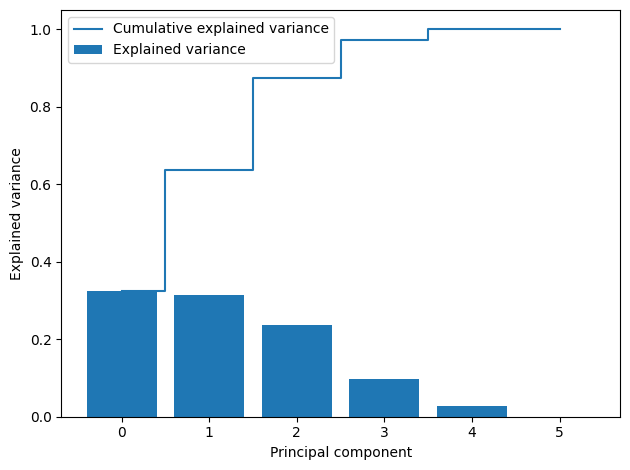

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


pca = PCA()
X_pca = pca.fit_transform(DF)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Застосуємо PCA з двома основними компонентами

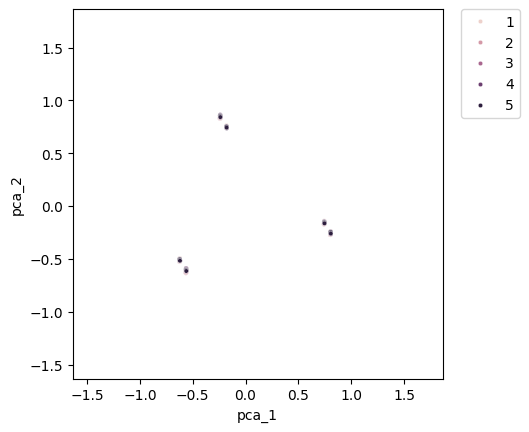

In [3]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(DF)
pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': Mines})


fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-1, pca_result.max()+1)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

А також tSNE

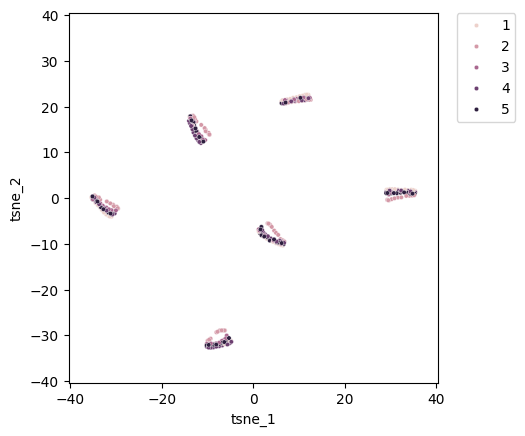

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(DF)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Mines})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Якось не дуже... Тому, дивлячись на графік, описуючий вклад компонент у дисперсію, варто спробувати збільшити розмірність до 3х вимірів.

Text(0.5, 0.92, 'tSNE')

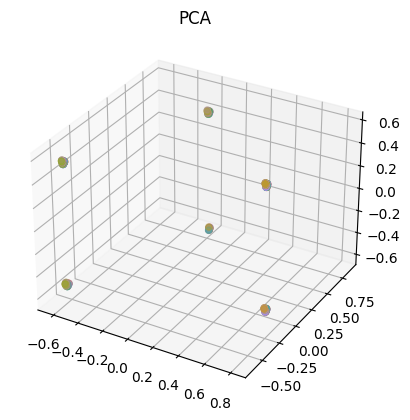

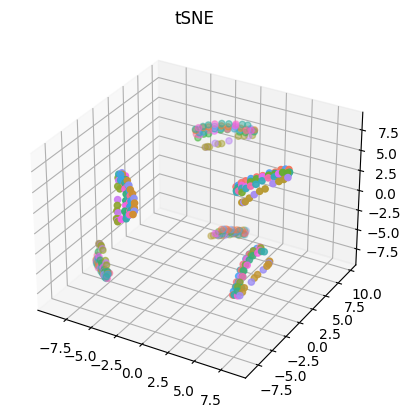

In [5]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(DF)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], c=sns.color_palette("husl", len(Mines)))
ax.set_title('PCA')


tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(DF)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne_result[:,0], tsne_result[:,1], tsne_result[:,2], c=sns.color_palette("husl", len(Mines)))
ax.set_title('tSNE')

Сильно краще не стало... Ну і ладно     : )

## 2. Кластерний аналіз

In [6]:
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

Стискання за допомогою K-Means до 16 кольорів

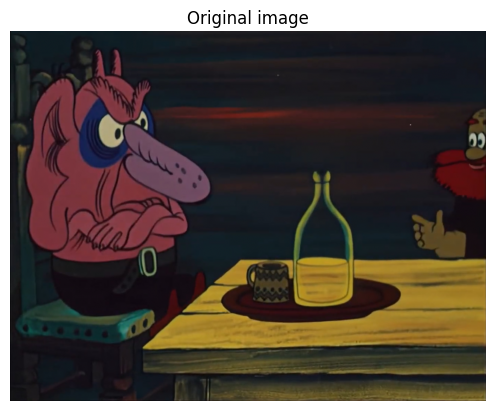

In [7]:
image = Image.open('data/chort.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255
w, h, d = original_shape = tuple(image_data_scaled.shape)
image_array = np.reshape(image_data_scaled, (w * h, d))
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image_data_scaled)

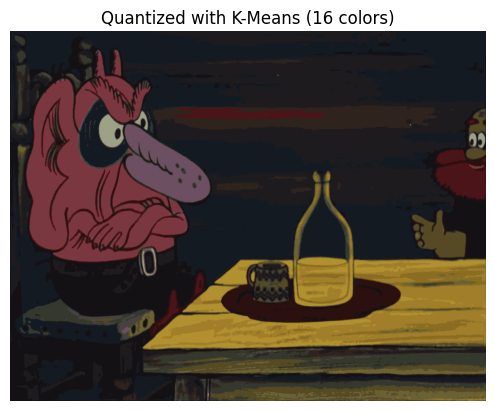

In [ ]:
n_colors = 16

image_array_sample = shuffle(image_array, random_state=0, n_samples=2500)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

Стискання за допомогою K-Means до 2 кольорів

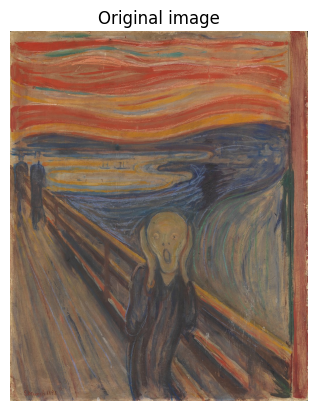

In [9]:
image = Image.open('data/scream.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255
w, h, d = original_shape = tuple(image_data_scaled.shape)
image_array = np.reshape(image_data_scaled, (w * h, d))
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image_data_scaled)

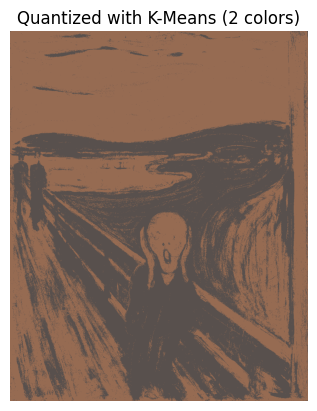

In [ ]:
n_colors = 2

image_array_sample = shuffle(image_array, random_state=0, n_samples=2500)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

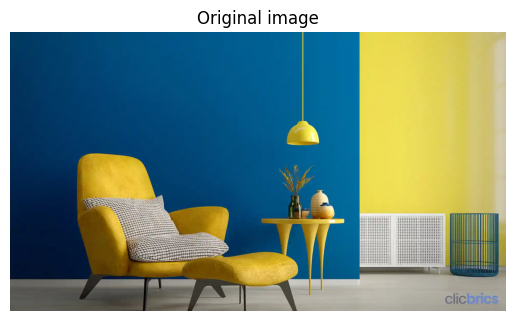

In [62]:
image = Image.open('data/room.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255
w, h, d = original_shape = tuple(image_data_scaled.shape)
image_array = np.reshape(image_data_scaled, (w * h, d))
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image_data_scaled)

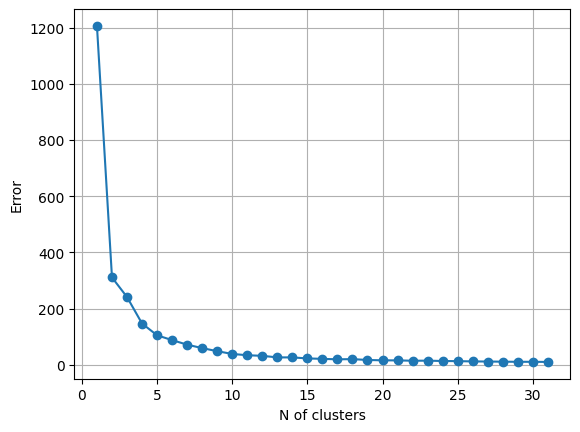

In [63]:
Error =[]
for n_colors in range(1, 32):
    image_array_sample = shuffle(image_array, random_state=0, n_samples=5000)
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(image_array_sample)

    Error.append(kmeans.inertia_)

plt.plot(range(1, 32), Error, marker = 'o')
plt.xlabel('N of clusters')
plt.ylabel('Error')
plt.grid()
plt.show()

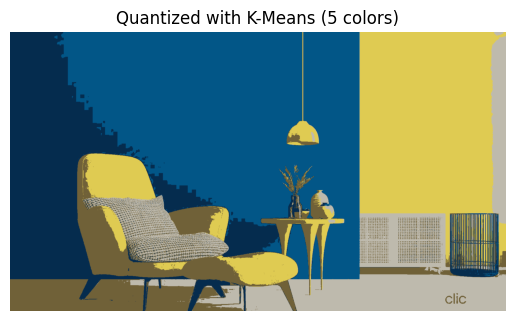

In [91]:
n = 5
image_array_sample = shuffle(image_array, n_samples=10000)
kmeans = KMeans(n_clusters=n, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)
plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

## 3. Обробка та класифікація текстових даних

In [103]:
tweets = pd.read_csv("data\gender_tweets.csv")
tweets = tweets[["gender", "text"]]
tweets = tweets.dropna()

print(len(tweets.index))

19953


In [104]:
# from nltk import download
# download('stopwords')
from nltk.corpus import stopwords
import re
import string


stop_words = stopwords.words("english")

def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    # text = re.sub('щч', ' ', text) 
    text = re.sub('\s{2,}', ' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text


texts = tweets["text"]
tweets["text"] = [clean_text(t) for t in texts]

tweets.head(10)


,gender,text
0,male,robbie e responds critics win eddie edwards
1,male,‰ыпit felt like friends living story them‰ыќ
2,male,absolutely adore louis starts songs hits hard ...
3,male,hi looking url use typically see advanced user
4,female,watching neighbours sky catching neighbs xxx щ...
5,female,ive seen people train lamps chairs tvs etc
6,brand,thank patience take care issue
7,male,gala bingo clubs bought еј uk largest high str...
8,female,pic defines mcd fangirls fanboys mcd shippers xd
9,female,lovely tree year never seen gorgeous


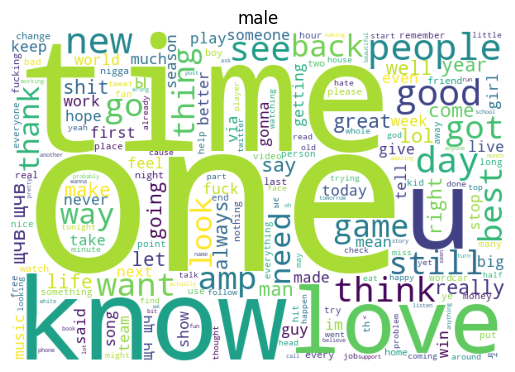

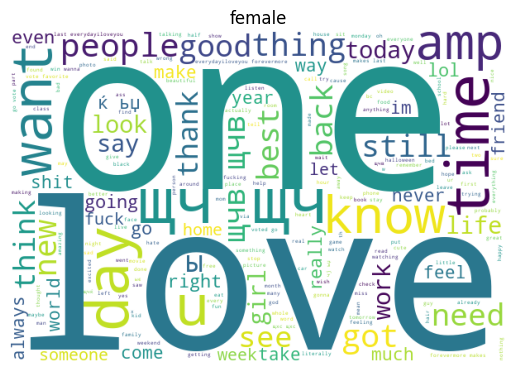

In [105]:
from wordcloud import WordCloud

def visualize(label):
    text = ''
    for msg in tweets[tweets['gender'] == label]['text']:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(label)
    plt.show()

visualize('male')
visualize('female')

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(tweets["text"], tweets["gender"], test_size=0.25)

vectorizer = TfidfVectorizer(max_df=0.7, min_df=5)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

model = RandomForestClassifier(n_estimators=100, criterion='gini')
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [115]:
print('Random Forest')
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

Random Forest
              precision    recall  f1-score   support

       brand       0.57      0.53      0.55      1462
      female       0.45      0.58      0.51      1664
        male       0.41      0.37      0.39      1587
     unknown       0.14      0.01      0.01       276

    accuracy                           0.47      4989
   macro avg       0.39      0.37      0.37      4989
weighted avg       0.45      0.47      0.46      4989

[[778 361 318   5]
 [218 971 471   4]
 [284 707 593   3]
 [ 91 107  76   2]]
0.46983363399478856


In [111]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [112]:
print('Random Forest')
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

Random Forest
              precision    recall  f1-score   support

       brand       0.55      0.54      0.54      1462
      female       0.47      0.56      0.51      1664
        male       0.42      0.42      0.42      1587
     unknown       0.00      0.00      0.00       276

    accuracy                           0.48      4989
   macro avg       0.36      0.38      0.37      4989
weighted avg       0.45      0.48      0.46      4989

[[787 329 346   0]
 [235 935 494   0]
 [310 610 667   0]
 [101 101  74   0]]
0.4788534776508318


c:\Users\matki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo